In [1]:
# Cargo las librerías necesarias
from sklearn.metrics import confusion_matrix
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
from os import scandir, getcwd
from os.path import abspath
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import pickle
from joblib import dump, load
import pandas as pd


# Seteo de paths y archivos de prueba
PATH_POSITIVE_TRAIN = "data/train/pedestrians/"
PATH_NEGATIVE_TRAIN = "data/train/background/"
PATH_POSITIVE_TEST = "data/test/pedestrians/"
PATH_NEGATIVE_TEST = "data/test/background/"
EXAMPLE_POSITIVE = PATH_POSITIVE_TEST + "AnnotationsPos_0.000000_crop_000011b_0.png"
EXAMPLE_NEGATIVE = PATH_NEGATIVE_TEST + "AnnotationsNeg_0.000000_00000002a_0.png"

### Seccion 1. Implementación funciones para el cálculo del descriptor LBP

A continuación se encuentran las funciones para el calculo del descriptor LBP

In [2]:
def get_pixel_value(imagen, x_pos, y_pos):
    """
    Función para obtener el valor numérico de un determinado pixel.
    
    Parámetros:
     - imagen: imagen a analizar
     - x_pos: posición del pixel en el eje X
     - y_pos: posición del pixel en el eje Y
     
     Retorna:
     - valor del pixel
    """
    valor = 0
    try:
        valor = imagen[x_pos, y_pos]
    except:
        pass
    return valor

def get_bin_info(imagen, punto, x_pos, y_pos):
    """
    Función que ejecuta el thresholding para el algoritmo LBP.
    
    Parámetros:
     - imagen: imagen a analizar
     - punto: valor del pixel central
     - x_pos: posición del pixel en el eje X
     - y_pos: posición del pixel en el eje Y
     
     Retorna:
     - valor del thresholding, 0 o 1
    """
    valor = get_pixel_value(imagen, x_pos, y_pos)
    valor_binario = 1 if valor >= punto else 0
    return valor_binario


def get_LBP(imagen):
    """
    Función que calcula el descritptor LBP para una imagen
    
    Parámetros:
     - imagen: imagen a analizar
     
     Retorna:
     - array del descritptor LBP
    """
    alto_maximo = imagen.shape[0]
    ancho_maximo = imagen.shape[1]

    lbp_array = np.array([])

    for wx in np.arange(0, alto_maximo - 8, 8):
        for wy in np.arange(0, ancho_maximo - 8, 8):

            mapa_textura = np.zeros((16, 16, 3), np.uint8)

            for x in np.arange(wx, wx+16, 1):
                for y in np.arange(wy, wy+16, 1):

                    # Variable auxiliar para almacenar el valor binario
                    binario_punto = []

                    # Obtengo la informacion de cada pixel y los 8 que estan alrededor
                    punto = get_pixel_value(imagen, x, y)  # Fila columna
                    arr_izq = get_bin_info(imagen, punto, x - 1, y - 1)
                    binario_punto.append(arr_izq)
                    arr_med = get_bin_info(imagen, punto, x - 1, y)
                    binario_punto.append(arr_med)
                    arr_der = get_bin_info(imagen, punto, x - 1, y + 1)
                    binario_punto.append(arr_der)
                    der_med = get_bin_info(imagen, punto, x, y + 1)
                    binario_punto.append(der_med)
                    der_ab = get_bin_info(imagen, punto, x + 1, y + 1)
                    binario_punto.append(der_ab)
                    ab_med = get_bin_info(imagen, punto, x + 1, y)
                    binario_punto.append(ab_med)
                    ab_izq = get_bin_info(imagen, punto, x + 1, y - 1)
                    binario_punto.append(ab_izq)
                    izq_med = get_bin_info(imagen, punto, x, y - 1)
                    binario_punto.append(izq_med)

                    # Obtengo el valor decimal a partir del binario
                    valor_decimal = int(''.join(map(str, binario_punto)), 2)

                    # Agrego el valor al mapa textura
                    mapa_textura[x-wx, y-wy] = valor_decimal

            # Calculo el histograma
            hist = cv2.calcHist([mapa_textura], [0], None, [256], [0, 256])
            
            # Normalizo
            cv2.normalize(hist, hist)

            # Me aseguro que sea 1 dimensional
            hist2 = hist.ravel()
            # Lo agrego a la salida
            lbp_array = np.append(lbp_array, hist2)
    return(lbp_array)


In [4]:
def loadTrainingData():
    """
    Funcion para leer los datos de entrenamiento
    
    Retorna:
    trainingData -- matriz con las instancias
    classes --      vector con las clases de cada instancia
    """

    # Matriz de descriptores
    trainingData = np.array([])
    trainingDataNeg = np.array([])

    ################################################
    # Casos positivos
    # Obtengo la lista de casos positivos
    listFiles = [abspath(arch.path) for arch in scandir(PATH_POSITIVE_TRAIN) if arch.is_file()]
    # Itero los archivos
    # for file in listFiles:
    for i in tqdm(range(len(listFiles))):
        file = listFiles[i]
        # Leo la imagen
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        # Calculo el LBP
        lbp = get_LBP(img)
        # Agrego a trainingData
        trainingData = np.hstack((trainingData, lbp))
    print("Leidas " + str(len(listFiles)) + " imágenes de entrenamiento -> positivas")
    # Hago un reshape
    trainingData = trainingData.reshape((len(listFiles), len(lbp)))
    # Genero el vector de clases
    classes = np.ones(len(listFiles))

    ################################################
    # Casos negativos
    # Obtengo la lista de casos positivos
    listFilesNeg = [abspath(arch.path) for arch in scandir(PATH_NEGATIVE_TRAIN) if arch.is_file()]
    # Itero los archivos
    # for file in listFilesNeg:
    for i in tqdm(range(len(listFilesNeg))):
        file = listFilesNeg[i]
        # Leo la imagen
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        # Calculo el LBP
        lbp = get_LBP(img)
        # Agrego a trainingData
        trainingDataNeg = np.hstack((trainingDataNeg, lbp))
    print("Leidas " + str(len(listFilesNeg)) + " imágenes de entrenamiento -> negativas")
    # Hago un reshape
    trainingDataNeg = trainingDataNeg.reshape((len(listFilesNeg), len(lbp)))
    # Genero el vector de clases
    classesNeg = np.zeros(len(listFilesNeg))

    # Merge de los datos
    trainingData = np.concatenate((trainingData, trainingDataNeg), axis=0)
    classes = np.concatenate((classes, classesNeg), axis=0)
    return trainingData, classes

def loadTestingData():
    """
    Funcion para leer los datos de testing
    
    Retorna:
    testingData -- matriz con las instancias de testing
    classes --     vector con las clases de cada instancia
    """

    # Matriz de descriptores
    testingData = np.array([])
    testingDataNeg = np.array([])

    ################################################
    # Casos positivos
    # Obtengo la lista de casos positivos
    listFiles = [abspath(arch.path) for arch in scandir(PATH_POSITIVE_TEST) if arch.is_file()]
    # Itero los archivos
    for i in tqdm(range(len(listFiles))):
        file = listFiles[i]
        # Leo la imagen
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        # Calculo el LBP
        lbp = get_LBP(img)
        # Agrego a testingData
        testingData = np.hstack((testingData, lbp))
    print("Leidas " + str(len(listFiles)) + " imágenes de entrenamiento -> positivas")
    # Hago un reshape
    testingData = testingData.reshape((len(listFiles), len(lbp)))
    # Genero el vector de clases
    classes = np.ones(len(listFiles))

    ################################################
    # Casos negativos
    # Obtengo la lista de casos positivos
    listFilesNeg = [abspath(arch.path) for arch in scandir(PATH_NEGATIVE_TEST) if arch.is_file()]
    # Itero los archivos
    for i in tqdm(range(len(listFilesNeg))):
        file = listFilesNeg[i]
        # Leo la imagen
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        # Calculo el LBP
        lbp = get_LBP(img)
        # Agrego a testingData
        testingDataNeg = np.hstack((testingDataNeg, lbp))
    print("Leidas " + str(len(listFilesNeg)) + " imágenes de entrenamiento -> negativas")
    # Hago un reshape
    testingDataNeg = testingDataNeg.reshape((len(listFilesNeg), len(lbp)))
    # Genero el vector de clases
    classesNeg = np.zeros(len(listFilesNeg))

    # Merge de los datos
    testingData = np.concatenate((testingData, testingDataNeg), axis=0)
    classes = np.concatenate((classes, classesNeg), axis=0)
    return testingData, classes


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Función para graficar una matriz de confusion
    
    Parámetros:
    cm --      matriz de confusion
    classes -- etiquetas de las clases
    title --   título del grafico
    cmap --    colores a emplear para graficar
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
def test(imagen, clasificador):
    """
    Funcion para predecir el tipo de una muestra
    
    Parámetros:
    imagen --       ruta de la imagen a leer
    clasificador -- clasificador de sklearn ya entrenado
    
    Retorna:
    valor -- retorna la predicción realizada
    """
    # Calculo el LBP
    lbp = get_LBP(imagen)
    lbp2 = lbp.reshape((1, -1))
    return(clasificador.predict(lbp2))

In [4]:
# -----------------------------
# Ejecución de la prueba
# -----------------------------

# Obtengo los datos de trainning
X_Train, y_train = loadTrainingData()
X_Train.size
# Dimensiones :p
X_Train.ndim
# Alto por ancho
X_Train.shape

# Guardo X_Train y y_train
np.save("X_Train_lbp", X_Train)
np.save("y_train_lbp", y_train)

#X_Train = np.load("X_Train_lbp.npy")
#y_train = np.load("y_train_lbp.npy")

# Creo una SVM con kernel linear
clf = SVC(kernel="linear")
# Entreno la SVM
clf.fit(X_Train, y_train)

dump(clf, 'LBP_clf.joblib')
#clf = load('LBP_clf.joblib')

# Pruebo con imágenes
# Ejemplo negativo
img_neg = cv2.imread(EXAMPLE_NEGATIVE, cv2.IMREAD_GRAYSCALE)
res = test(img_neg, clf)
print(EXAMPLE_NEGATIVE, " fue clasificado como: ", res)

# Ejemplo positivo
img_pos = cv2.imread(EXAMPLE_POSITIVE, cv2.IMREAD_GRAYSCALE)
res = test(img_pos, clf)
print(EXAMPLE_POSITIVE, " fue clasificado como: ", res)

  0%|          | 0/2390 [00:00<?, ?it/s]

Leidas 1916 imágenes de entrenamiento -> positivas


100%|██████████| 2390/2390 [13:08<00:00,  2.39it/s]


Leidas 2390 imágenes de entrenamiento -> negativas
data/test/background/AnnotationsNeg_0.000000_00000002a_0.png  fue clasificado como:  [0.]
data/test/pedestrians/AnnotationsPos_0.000000_crop_000011b_0.png  fue clasificado como:  [1.]


### Seccion 2. Prueba sobre el dataset de test

  0%|          | 0/600 [00:00<?, ?it/s]

Leidas 500 imágenes de entrenamiento -> positivas


100%|██████████| 600/600 [03:24<00:00,  2.78it/s]


Leidas 600 imágenes de entrenamiento -> negativas
              precision    recall  f1-score   support

  background       0.99      0.99      0.99       600
 pedestrians       0.99      0.98      0.99       500

   micro avg       0.99      0.99      0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100



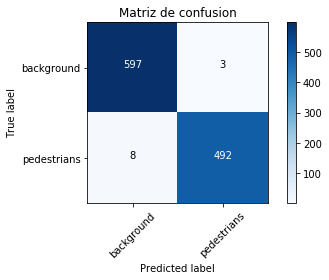

In [5]:
# -----------------------------------
# Mejoras 1. Evaluación del modelo
# -----------------------------------

# Obtengo los datos de test
X_Test, y_test = loadTestingData()

# Guardo X_Test y y_test
np.save("X_Test_lbp", X_Test)
np.save("y_test_lbp", y_test)

#X_Test = np.load("X_Test_lbp.npy")
#y_test = np.load("y_test_lbp.npy")


target_names = ['background', 'pedestrians']

# Realizo predicciones sobre el dataset de test
predicciones = clf.predict(X_Test)

# Calculo la matriz de confusion
cnf_matrix = confusion_matrix(y_test, predicciones)

# Grafico la matriz de confusion
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Matriz de confusion')
plt.savefig("img/LBP_Confusion.png")

# Imprimo un reporte de la clasificación
print(classification_report(y_test, predicciones, target_names=target_names))


### Seccion 3. Implementación de validación cruzada

In [4]:
# -----------------------------------
# Mejoras 2. K-Fold Cross Validation
# -----------------------------------
# Hago un merge de los datos de train y test
allData = np.concatenate((X_Train, X_Test), axis=0)
allClasses = np.concatenate((y_train, y_test))

np.save("allData_lbp", allData)
np.save("allClasses_lbp", allClasses)
#clf = load('LBP_clf.joblib')
#allData = np.load("allData_lbp.npy")
#allClasses = np.load("allClasses_lbp.npy")

# Ahora implemento 10 Fold Cross Validation
scores = cross_val_score(SVC(kernel="linear"), allData, allClasses, cv=10, n_jobs = 1)
# Con esto puede calcular la exactitud promedio y la varianza
print("Exactitud Promedio (Varianza): %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

np.set_printoptions(precision=4)
print("Exactitud de cada fold= {}".format(scores))

Exactitud Promedio (Varianza): 0.9939 (+/- 0.0055)
Exactitud de cada fold= [0.9926 0.9926 0.9926 0.9945 0.9982 0.9926 0.9963 0.9926 0.9889 0.9981]


In [3]:
allData = np.load("allData_lbp.npy")
allClasses = np.load("allClasses_lbp.npy")

### Seccion 4. Exploración de hiperparámetros

In [4]:
# Mejoras 3. Evaluación de parámetros SVM
# -----------------------------------
def grid_search(classifier, X_train, y_train, gparams,
                score='accuracy', cv=10, jobs=-1):
    """
    Realizo una búsqueda de hiperparametros utilizando una grilla
    con la función GridSearchCV de sklearn.model_selection

    Parámetros:
    classifier -- sklearn ML algorithm
    X_train --    Training features
    y_train --    Training labels
    gparams --    Dictionary of parameters to be screened
    score --      Scoring metric
    cv --         K value for Cross Validation
    jobs --       Cores (-1 for all)

    Retorna:
        Mejor modelo
    """
    
    # Inicializo la clase de GridSearch
    gd_sr = GridSearchCV(estimator=classifier,
                         param_grid=gparams,
                         scoring=score,
                         cv=cv,
                         n_jobs=jobs)

    # Hago un fit de los datos de train
    gd_sr.fit(X_train, y_train)

    # Resultados
    best_result = gd_sr.best_score_
    print("Mejor Resultado = {}".format(best_result))

    # Get the best parameters
    best_parameters = gd_sr.best_params_
    print("Mejores parámetros = {}".format(best_parameters))

    return gd_sr


# Defino los parámetros de búsqueda
params = {'C': [0.01, 1, 10],
          'gamma': [0.01, 1, 10],
          'kernel': ['linear', 'rbf', 'poly']
         }

results = grid_search(SVC(), allData, allClasses, params, score='accuracy', cv=5, jobs=2)

# Guardo los resultados de gridsearch
dump(results, 'results_gridsearch_LBP.pkl')

# Otengo todos los resultados de grid search y armo una tabla
cv_results = results.cv_results_
scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
scores_grid_search = scores_df[['params', 'mean_test_score', 'std_test_score']]
print(scores_grid_search)

Mejor Resultado = 0.9942656307806141
Mejores parámetros = {'C': 0.01, 'gamma': 1, 'kernel': 'poly'}
                                            params  mean_test_score  \
26        {'C': 10, 'gamma': 10, 'kernel': 'poly'}         0.994266   
23         {'C': 10, 'gamma': 1, 'kernel': 'poly'}         0.994266   
20      {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}         0.994266   
5        {'C': 0.01, 'gamma': 1, 'kernel': 'poly'}         0.994266   
19       {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}         0.994266   
8       {'C': 0.01, 'gamma': 10, 'kernel': 'poly'}         0.994266   
17         {'C': 1, 'gamma': 10, 'kernel': 'poly'}         0.994266   
14          {'C': 1, 'gamma': 1, 'kernel': 'poly'}         0.994266   
24      {'C': 10, 'gamma': 10, 'kernel': 'linear'}         0.993896   
21       {'C': 10, 'gamma': 1, 'kernel': 'linear'}         0.993896   
18    {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}         0.993896   
9      {'C': 1, 'gamma': 0.01, 'kernel': 'linear

/home/crohr/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/crohr/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/crohr/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/crohr/anaconda3/lib/python3.

In [6]:
scores_df.to_csv("LBP_hiperparametros.csv", index=False)